
# Combined Shape Classification and Processing Notebook

This notebook combines functionalities for:
- Classifying regular shapes and titling them.
- Regularizing shapes (e.g., smoothing or aligning).
- Finding the symmetry of the shape.
- Completing occluded images.


In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
# Directory structure
base_dir = r"dataset\closed"
categories = ['circle', 'rectangle', 'irregular', 'star','rounded_rec', 'ellipse']  # Add all folder names

In [ ]:
# Data storage
data = []
labels = []

# Load data
for category in categories:
    folder_path = os.path.join(base_dir, category)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith('.csv'):
            # Read CSV file
            points = pd.read_csv(file_path)
            data.append(points.values)  # Store points as numpy array or DataFrame
            labels.append(category)  # Store the label

In [ ]:
data[0]

array([[530.83688354, 386.50518799],
       [529.09716797, 386.38467407],
       [527.35690308, 386.27212524],
       [525.6159668 , 386.17050171],
       [523.87417603, 386.08456421],
       [522.13162231, 386.01647949],
       [520.3883667 , 385.9692688 ],
       [518.6446228 , 385.94714355],
       [516.90078735, 385.95223999],
       [515.1572876 , 385.98840332],
       [513.41485596, 386.05947876],
       [511.67443848, 386.16903687],
       [509.93722534, 386.32113647],
       [508.20471191, 386.51953125],
       [506.47875977, 386.76849365],
       [504.76168823, 387.07275391],
       [503.0562439 , 387.43643188],
       [501.3656311 , 387.86376953],
       [499.69393921, 388.3598938 ],
       [498.04534912, 388.92810059],
       [496.42507935, 389.57247925],
       [494.83862305, 390.29611206],
       [493.29171753, 391.10079956],
       [491.79095459, 391.98852539],
       [490.34179688, 392.95822144],
       [488.89157104, 393.92611694],
       [487.38150024, 394.79785156],
 

In [ ]:
unique_labels = list(set(labels))

print(unique_labels)

['irregular', 'circle', 'rectangle', 'ellipse', 'star', 'rounded_rec']


In [ ]:
import matplotlib.pyplot as plt

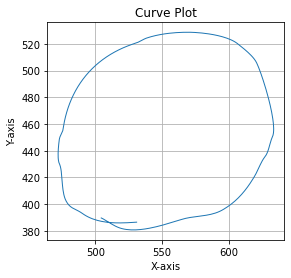

In [ ]:
x_coords, y_coords = zip(*data[0])

# Plot the curve
plt.plot(x_coords, y_coords, linewidth = 1)  # Use marker='o' to show points
plt.title('Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal')
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()

#**Identifying the shape**

In [ ]:
def distances_to_centroid(points):
    # Convert to numpy array for easier calculations
    points = np.array(points)

    # Calculate centroid
    centroid = points.mean(axis=0)

    # Compute distances to centroid
    distances = np.sqrt(((points - centroid) ** 2).sum(axis=1))

    return distances

In [ ]:
def calculate_curvature(points):
    points = np.array(points)
    num_points = len(points)

    # Calculate angles between segments
    curvatures = []
    for i in range(1, num_points - 1):
        p1 = points[i - 1]
        p2 = points[i]
        p3 = points[i + 1]

        # Vectors
        v1 = p2 - p1
        v2 = p3 - p2

        # Angle between vectors
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
         # Prevent division by zero
        if norm_v1 == 0 or norm_v2 == 0:
            curvatures.append(0.0)
            continue

        cos_angle = dot_product / (norm_v1 * norm_v2)

        # Clamp the cosine value to avoid invalid inputs for arccos
        cos_angle = np.clip(cos_angle, -1.0, 1.0)

        angle = np.arccos(cos_angle)
        curvatures.append(angle)

    curvatures = np.array(curvatures)
    padded_curvatures = np.concatenate(([0], curvatures, [0]))

    return padded_curvatures

In [ ]:
max_len = 1000
def extract_features(points):
    # Calculate curvature vector
    curvatures = calculate_curvature(points)

    # Calculate distance vector to centroid
    distances = distances_to_centroid(points)

    # Combine features into a single matrix
    # Ensure the feature vectors are of the same length
    if len(curvatures) != len(distances):
        min_len = min(len(curvatures), len(distances))
        curvatures = curvatures[:min_len]
        distances = distances[:min_len]

    features = np.array([[d, c] for d, c in zip(distances, curvatures)])

    if len(features) < max_len:
        # Pad with [-1, -1]
        padding_length = max_len - len(features)
        features_padded = np.vstack([features, np.full((padding_length, 2), -1)])
    else:
        # Truncate
        features_padded = features[:max_len]

    return features_padded

In [ ]:
labels[0]

'circle'

#**Regularizing the Shape**

In [ ]:
X = []
Y = []

for curve, label in zip(data, labels):
    features = extract_features(curve)
    if features.size > 0:  # Ensure that features are not empty
        X.append(features)
        Y.append(label)
# Convert lists to numpy arrays


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X[0]

array([[ 6.65879147e+01,  0.00000000e+00],
       [ 6.72252079e+01,  4.57826272e-03],
       [ 6.78939951e+01,  6.27668995e-03],
       ...,
       [-1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00]])

In [ ]:
X.shape

(88, 1000, 2)

In [ ]:
X = X.reshape(X.shape[0], -1)

In [ ]:
X.shape

(88, 2000)

In [ ]:
Y[0]

'circle'

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# test_size: proportion of the dataset to include in the test split (20% here)
# random_state: seed used by the random number generator for reproducibility

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, Y)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
Y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(Y_test, Y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00         8
     ellipse       1.00      1.00      1.00         4
   irregular       1.00      1.00      1.00         3
   rectangle       1.00      1.00      1.00         5
 rounded_rec       1.00      1.00      1.00         3
        star       1.00      1.00      1.00         4

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

Confusion Matrix:
[[8 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 4]]


In [ ]:
from joblib import dump, load
dump(model, 'model1.joblib')

['model1.joblib']

In [ ]:
c1 = pd.read_csv(r"rectangle\r8.csv")

In [ ]:
c1

,x,y
0,495.505798,423.644806
1,493.332916,423.708527
2,491.159821,423.764099
3,488.986511,423.811798
4,486.813049,423.850952
...,...,...
395,506.168274,425.642273
396,504.011444,425.370972
397,501.859436,425.064148
398,499.715363,424.706543


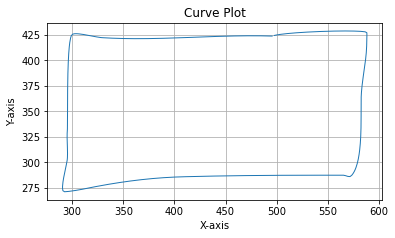

In [ ]:
x_coords = c1['x']
y_coords = c1['y']

# Plot the curve
plt.plot(x_coords, y_coords, linewidth = 1)  # Use marker='o' to show points
plt.title('Curve Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect('equal')
plt.grid(True)  # Optional: Add grid for better visualization
plt.show()

In [ ]:
fv = extract_features(c1)

In [ ]:
fv.shape

(1000, 2)

In [ ]:
fv = fv.reshape(1, -1)
fv.shape

(1, 2000)

In [ ]:
model.predict(fv)

array(['rectangle'], dtype='<U11')

In [ ]:
dist = distances_to_centroid(c1)
type(dist)

numpy.ndarray

In [ ]:
import numpy as np

def find_corners(points, angle_threshold=0.5, distance=5):
    def safe_arccos(x):
        return np.arccos(np.clip(x, -1.0, 1.0))

    def calculate_curvature(p1, p2, p3):
        v1 = np.array(p2) - np.array(p1)
        v2 = np.array(p3) - np.array(p2)
        dot_product = np.dot(v1, v2)
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 == 0 or norm_v2 == 0:
            return 0
        angle = safe_arccos(dot_product / (norm_v1 * norm_v2))
        return angle

    if not isinstance(points, np.ndarray):
        # Convert to NumPy array if it's not already
        points = points.to_numpy()

    num_points = len(points)
    corners = []
    marked_indices = set()

    i = 0
    loop_count = 0  # Counter to prevent infinite loop

    while loop_count < num_points:
        if i in marked_indices:
            i = (i + 1) % num_points
            loop_count += 1
            continue

        # Determine indices for curvature calculation with cyclic behavior
        p1 = points[i]
        p2 = points[(i + distance // 2) % num_points]
        p3 = points[(i + distance) % num_points]

        curvature = calculate_curvature(p1, p2, p3)
        if curvature > angle_threshold:
            corners.append(p2)
            # Mark neighbors to skip, handle cyclic behavior
            for j in range(-distance, distance + 1):
                marked_index = (i + j) % num_points
                marked_indices.add(marked_index)
            i = (i + distance) % num_points  # Move ahead to next to next point
        else:
            i = (i + 1) % num_points

        loop_count += 1

    return np.array(corners)


In [ ]:

# Find corners
corners = find_corners(c1)
print("Detected corners:", corners)

Detected corners: [[302.41921997 425.94772339]
 [290.50244141 274.53343201]
 [569.50390625 286.41070557]
 [588.18865967 424.72570801]]


In [ ]:
def calculate_dimensions(corners):
    def calculate_distance(p1, p2):
        return np.linalg.norm(np.array(p2) - np.array(p1))

    distances = []
    for j in range(len(corners) - 1):
        dist = calculate_distance(corners[j], corners[j + 1])
        distances.append(dist)

    # Alternate labeling as height and breadth
    heights = distances[::2]
    breadths = distances[1::2]

    avg_height = np.mean(heights) if heights else 0
    avg_breadth = np.mean(breadths) if breadths else 0

    return avg_height, avg_breadth

In [ ]:
from sklearn.decomposition import PCA

def pca_bounding_box(corners):
    pca = PCA(n_components=2)
    pca.fit(corners)
    mean = pca.mean_
    components = pca.components_

    # Project points onto the principal components
    projections = np.dot(corners - mean, components.T)

    min_proj = np.min(projections, axis=0)
    max_proj = np.max(projections, axis=0)

    # Define rectangle corners
    rectangle = np.array([
        mean + min_proj[0] * components[0] + min_proj[1] * components[1],
        mean + min_proj[0] * components[0] + max_proj[1] * components[1],
        mean + max_proj[0] * components[0] + max_proj[1] * components[1],
        mean + max_proj[0] * components[0] + min_proj[1] * components[1]
    ])

    return rectangle

In [ ]:
reg_corners = pca_bounding_box(corners)
reg_corners

array([[290.84908802, 268.98894401],
       [281.11913659, 424.61602212],
       [586.99986989, 443.73997352],
       [596.72982132, 288.11289541]])

In [ ]:
radius = np.mean(dist)

In [ ]:
center = c1.mean(axis =0)

In [ ]:
def generate_circle_points(center, radius, num_points=100):
    """
    Generate points on a circle in sequence at equal distances.

    Args:
    - center (tuple): The (x, y) coordinates of the circle's center.
    - radius (float): The radius of the circle.
    - num_points (int): The number of points to generate. Default is 100.

    Returns:
    - np.array: A numpy array of shape (num_points, 2) containing the (x, y) coordinates of the points.
    """
    h, k = center
    points = []

    # Increment angle by 2π/num_points for equal spacing
    delta_theta = 2 * np.pi / num_points

    for i in range(num_points):
        theta = i * delta_theta
        x = h + radius * np.cos(theta)
        y = k + radius * np.sin(theta)
        points.append((x, y))

    return np.array(points)

In [ ]:
import numpy as np

In [ ]:
np_path_XYs = np.genfromtxt(r"D:\Om Saran\ML\adobe\problems\problems\frag0.csv",delimiter = ',')
np_path_XY2s = np.genfromtxt(r"D:\Om Saran\ML\adobe\problems\problems\frag01_sol.csv",delimiter = ',')

In [ ]:
size = len(np.unique(np_path_XYs[:,0]))
size

10

In [ ]:
size2 = len(np.unique(np_path_XY2s[:,0]))
size2

4

In [ ]:
np_path_XYs[:,0] == 0

array([ True,  True,  True, ..., False, False, False])

In [ ]:
np_XYs = np_path_XYs[np_path_XYs[:,0] == 0][:,1:]

In [ ]:
np.unique(np_XYs[:,0])

array([0.])

In [ ]:
XY =[]
XY2 =[]

In [ ]:
for i in range(size):
    new_path = np_path_XYs[np_path_XYs[:,0] == i][:,2:]
    XY.append(new_path)

In [ ]:
for i in range(size2):
    new_path = np_path_XY2s[np_path_XY2s[:,0] == i][:,2:]
    XY2.append(new_path)

In [ ]:
import matplotlib.pyplot as plt

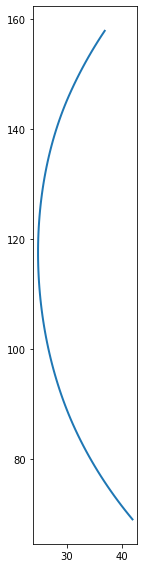

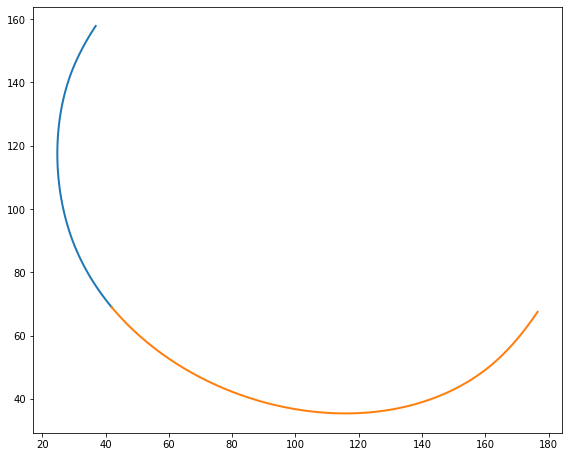

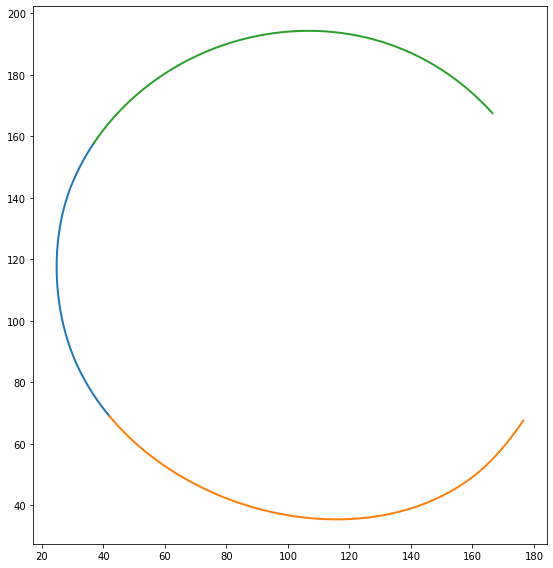

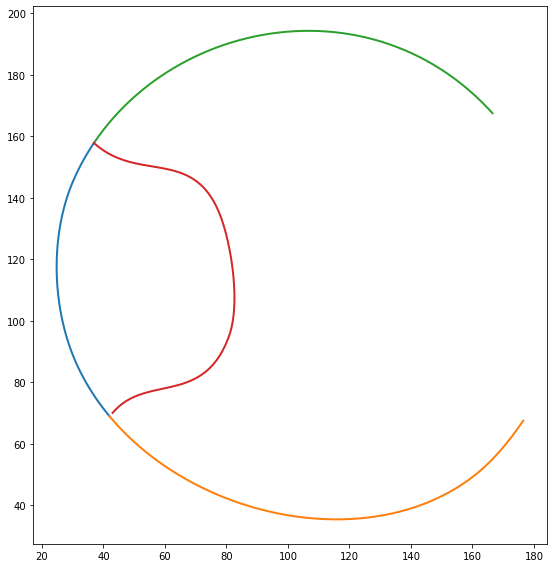

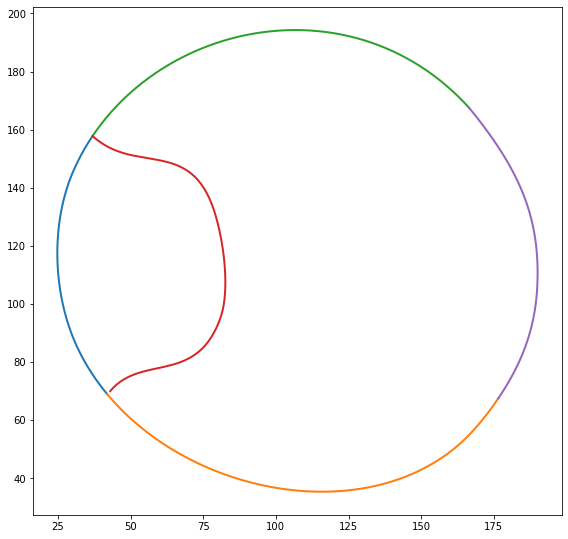

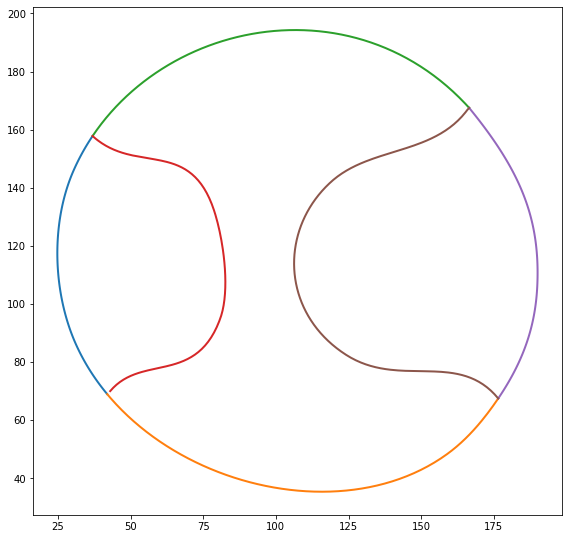

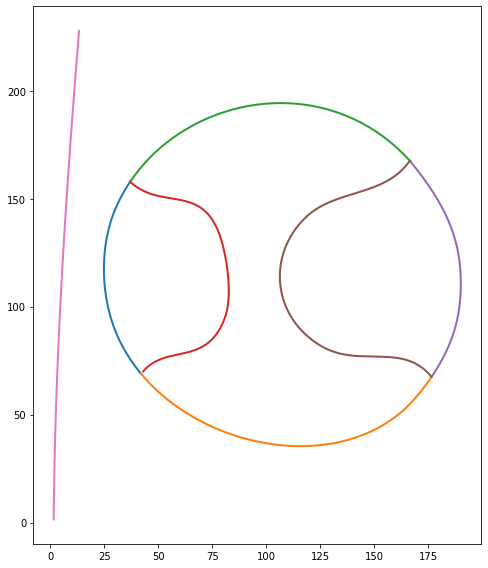

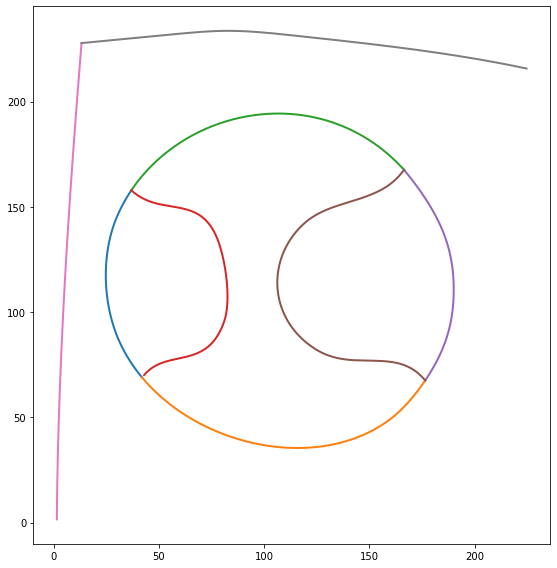

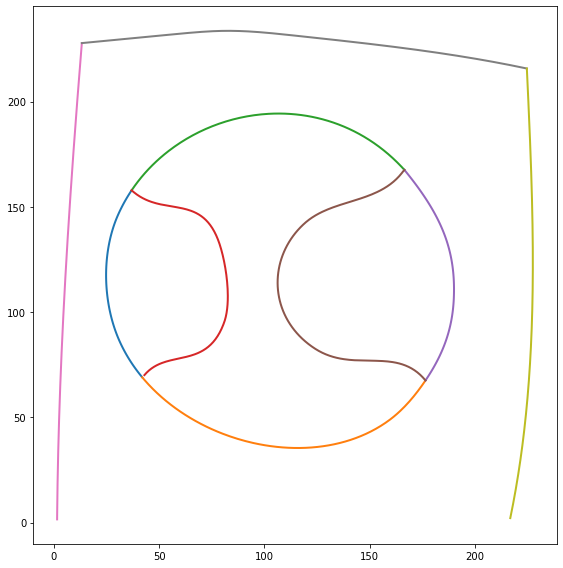

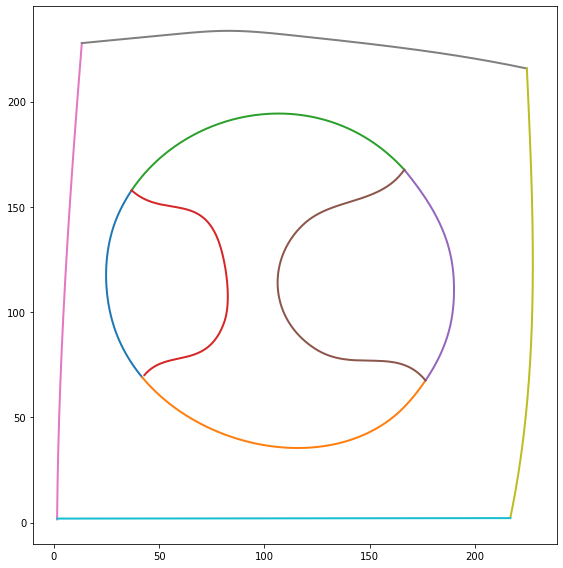

In [ ]:
for i in range(size):
    fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
    for j in range(i+1):
        ax.plot (XY[j][:, 0], XY[j][:, 1], linewidth =2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


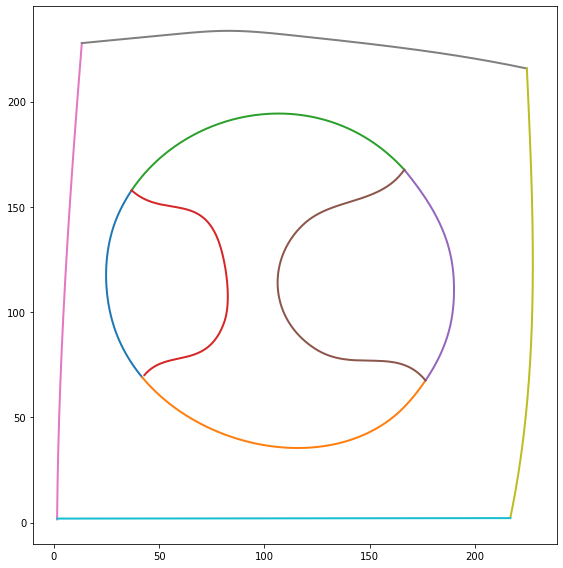

In [ ]:
fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
for i in range(size):
    ax.plot (XY[i][:, 0], XY[i][:, 1], linewidth =2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


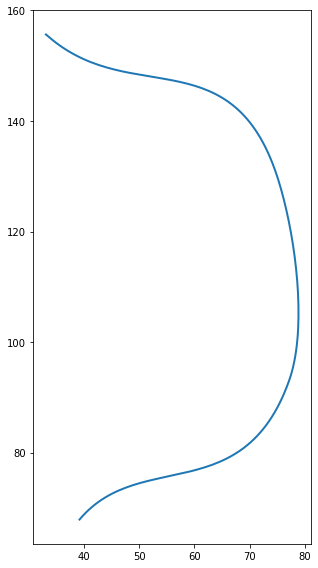

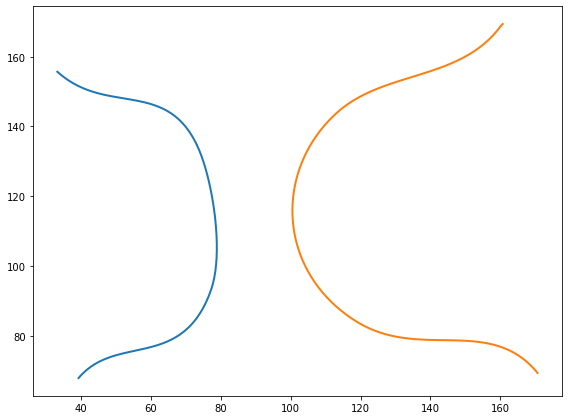

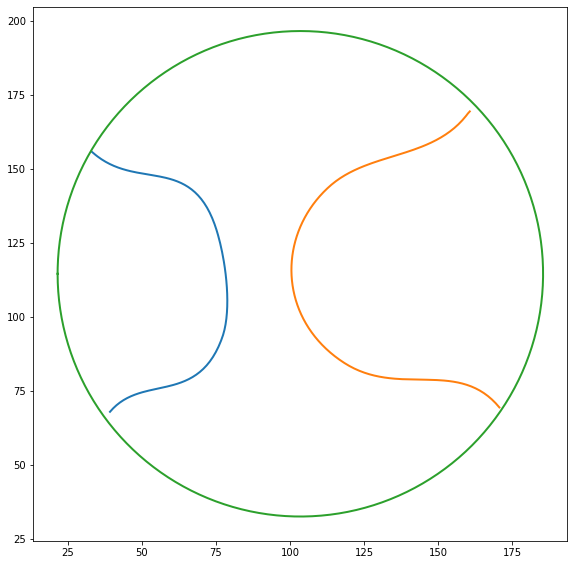

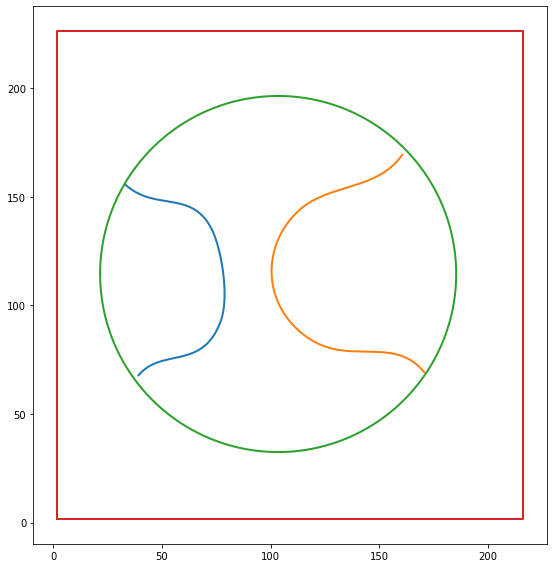

In [ ]:
for i in range(size2):
    fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
    for j in range(i+1):
        ax.plot (XY2[j][:, 0], XY2[j][:, 1], linewidth =2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

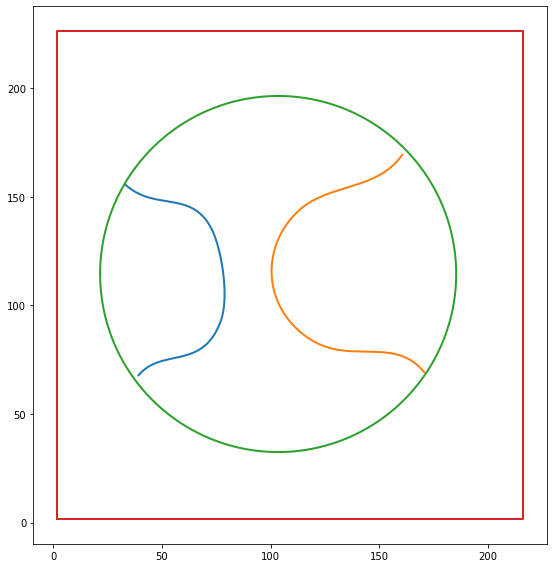

In [ ]:
fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
for i in range(size2):
    ax.plot (XY2[i][:, 0], XY2[i][:, 1], linewidth =2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


#**Finding Lines of Symmetry**

In [ ]:
len(XY)

10

In [ ]:
XY[0][0]
XY[0][len(XY[0])-1]

len(XY[0])

94

In [ ]:
start_points = []
end_points = []

for i in range(size):
    a = XY[i][0]
    b = XY[i][len(XY[i])-1]
    start_points.append(a);
    end_points.append(b);

In [ ]:
curve_num = {}
for i in range(2*size):
    curve_num[i] = i//2

In [ ]:
partner = {}
for i in range(0,2*size,2):
    partner[i] = i+1
for i in range(1,2*size,2):
    partner[i] = i-1

In [ ]:
umap = {}
for i in range(size):
    umap[2*i] = start_points[i]
    umap[2*i +1] = end_points[i]

In [ ]:
num_curves = size

In [ ]:
num_curves = size

# Initialize adjacency list with curve info
adjacency_list = [[] for _ in range(2 * num_curves)]  # 20 nodes for 10 curves

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Build the adjacency list
for i in range(num_curves):
    # Connect each curve's start and end points to each other
    adjacency_list[2 * i].append((2 * i + 1, i))  # Connect start to end
    adjacency_list[2 * i + 1].append((2 * i, i))  # Connect end to start

    for j in range(num_curves):
        if i != j:
            # Check distances for start points
            if euclidean_distance(start_points[i], start_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j, j))
            if euclidean_distance(start_points[i], end_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j + 1, j))
            # Check distances for end points
            if euclidean_distance(end_points[i], start_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j, j))
            if euclidean_distance(end_points[i], end_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j + 1, j))

In [ ]:
def dfs(node, start_node, visited, path, adj_list, partner, unique_cycles):
    # Track the path of nodes
    path.append(node)
    visited.add(node)

    for neighbor, curve_number in adj_list[node]:

        if len(path) ==2 and partner[path[0]] == path[1] and euclidean_distance(umap[path[0]], umap[path[1]]) < 5:
            curve_path =[]
            curve_path.append(curve_num[path[0]])
            cycle_representation = frozenset(curve_path)
            if cycle_representation not in unique_cycles and len(cycle_representation) > 0:
                unique_cycles[cycle_representation] = list(path) + [start_node]

        if neighbor == start_node and len(path) > 2:
            # Generate curve path from node path
            curve_path = []
            for i in range(len(path)-1):
                cur_node = path[i]
                next_node = path[i + 1]
                if partner[cur_node] == next_node:
                    curve_path.append(curve_num[cur_node])
            if partner[path[len(path)-1]] == neighbor:
                    curve_path.append(curve_num[neighbor])

            cycle_representation = frozenset(curve_path)
            if cycle_representation not in unique_cycles and len(cycle_representation) > 0:
                unique_cycles[cycle_representation] = list(path) + [start_node]
                #print(f"Added new cycle: {unique_cycles[cycle_representation]}")
        elif neighbor not in visited:
            dfs(neighbor, start_node, visited, path, adj_list, partner, unique_cycles)

    path.pop()
    visited.remove(node)

def find_closed_curves(adj_list, num_nodes):
    unique_cycles = {}

    for start_node in range(num_nodes):
        #print(f"Starting new DFS from start_node={start_node}")
        visited = set()
        dfs(start_node, start_node, visited, [], adj_list, partner, unique_cycles)
       # print(f"Completed DFS for start_node={start_node}\n")

   # print(f"Total Unique Cycles Found: {len(unique_cycles)}")
    return unique_cycles

# Number of nodes
num_nodes = len(adjacency_list)

# Find all closed curves
closed_curves = find_closed_curves(adjacency_list, num_nodes)


In [ ]:
closed_curves

{frozenset({0, 1, 2, 4}): [0, 1, 4, 5, 8, 9, 2, 3, 0],
 frozenset({0, 1, 2, 5}): [0, 1, 4, 5, 8, 11, 10, 2, 3, 0],
 frozenset({0, 3}): [0, 1, 4, 7, 6, 0],
 frozenset({1, 2, 3, 4}): [0, 3, 2, 9, 8, 5, 4, 1, 7, 6, 0],
 frozenset({1, 2, 3, 5}): [0, 3, 2, 9, 10, 11, 5, 4, 1, 7, 6, 0],
 frozenset({4, 5}): [2, 9, 8, 5, 11, 10, 2],
 frozenset({6, 7, 8, 9}): [12, 13, 18, 19, 16, 17, 14, 15, 12]}

In [ ]:
type(closed_curves)

dict

In [ ]:
len(closed_curves)

7

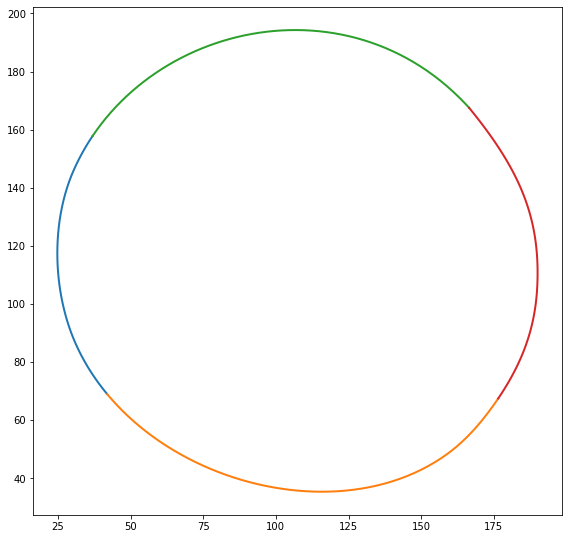

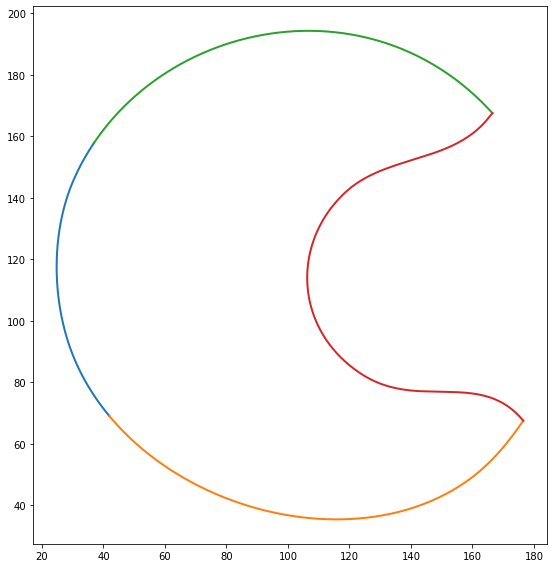

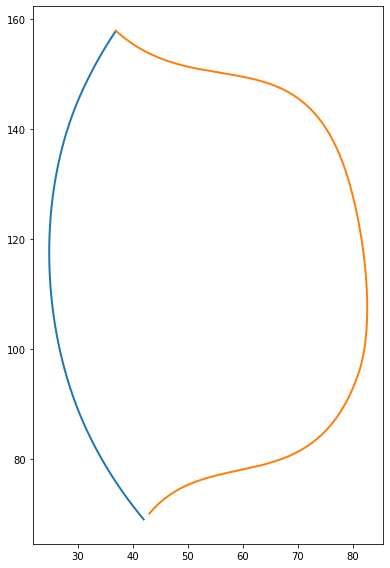

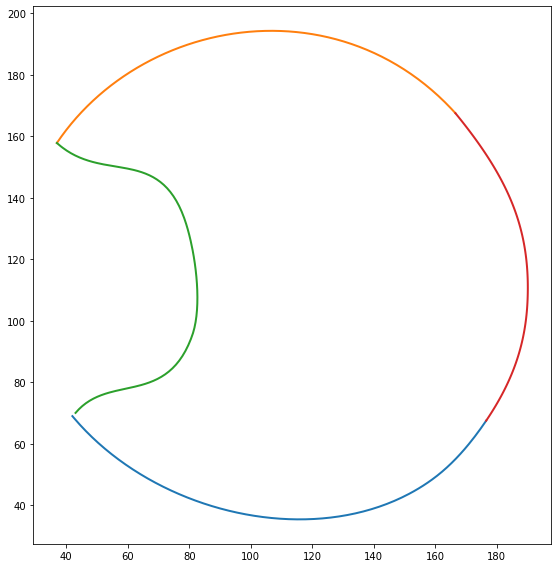

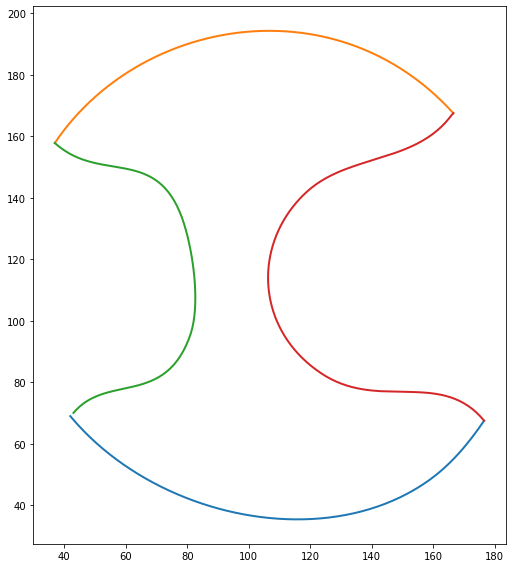

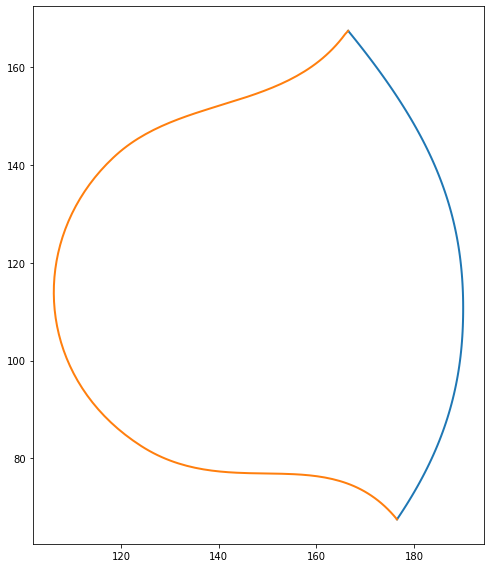

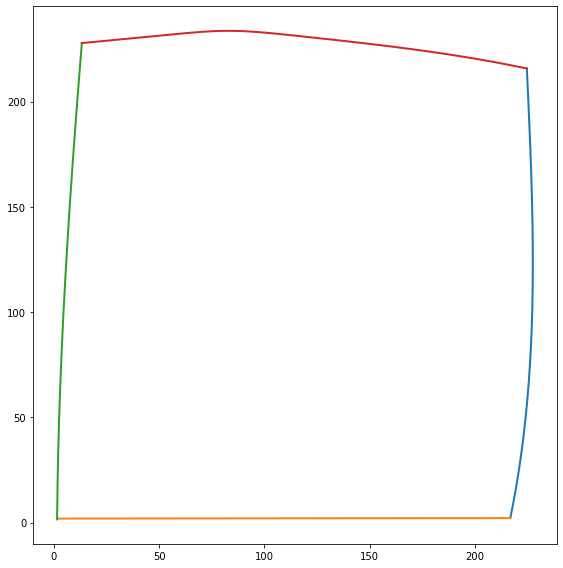

In [ ]:
for i, (curve_set, path) in enumerate(closed_curves.items()):
    fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
    for el in curve_set:
        ax.plot (XY[el][:, 0], XY[el][:, 1], linewidth =2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
import numpy as np

def reconstruct_single_curve(node_sequence, umap, XY, partner):
    curve_points = []
    i = 0

    while i < len(node_sequence) - 1:
        cur_node = node_sequence[i]
        next_node = node_sequence[i + 1]

        # Check if next node is the partner of the current node
        if partner[cur_node] != next_node:
            # Directly add the point if it's a partner
            i += 1
        else:
            # Find a curve in XY that starts or ends with the points corresponding to cur_node and next_node
            start_point = umap[cur_node]
            end_point = umap[next_node]
            found_curve = False

            for curve in XY:
                curve_start = curve[0]
                curve_end = curve[-1]

                if (np.array_equal(curve_start, start_point) and np.array_equal(curve_end, end_point)) or (np.array_equal(curve_start, end_point) and np.array_equal(curve_end, start_point)):
                    # If start_point and end_point match, add points to the curve
                    if np.array_equal(curve_start, start_point):
                        curve_points.extend(curve)
                    else:
                        curve_points.extend(curve[::-1])

                    found_curve = True
                    break

            if not found_curve:
                raise ValueError("Curve with the specified start and end points not found in XY.")

            # Move ahead to the next to next node
            i += 2

    return np.array(curve_points)

# Example usage
# node_sequence: the sequence of nodes in the closed curve
# umap: dictionary mapping node indices to points
# XY: list of curves where each curve is a sequence of points
# partner: dictionary mapping each node to its partner node



In [ ]:
from joblib import dump, load
loaded_model = load('model1.joblib')

['ellipse', 'circle', 'star', 'rectangle', 'irregular', 'rounded_rec']


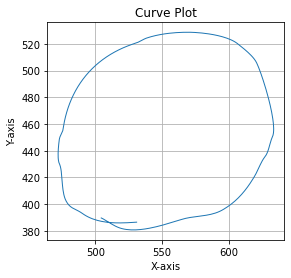

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

      circle       1.00      1.00      1.00         8
     ellipse       1.00      1.00      1.00         4
   irregular       1.00      1.00      1.00         3
   rectangle       1.00      1.00      1.00         5
 rounded_rec       1.00      1.00      1.00         3
        star       1.00      1.00      1.00         4

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

Confusion Matrix:
[[8 0 0 0 0 0]
 [0 4 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 4]]


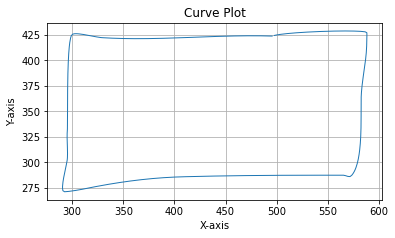

Detected corners: [[302.41921997 425.94772339]
 [290.50244141 274.53343201]
 [569.50390625 286.41070557]
 [588.18865967 424.72570801]]


In [ ]:
%run curves_model.ipynb

frozenset({8, 9, 6, 7})
[[  1.50858116   2.504601  ]
 [215.77230835   2.10592055]
 [224.69352722 214.67955017]
 [ 14.2784996  227.85400391]]


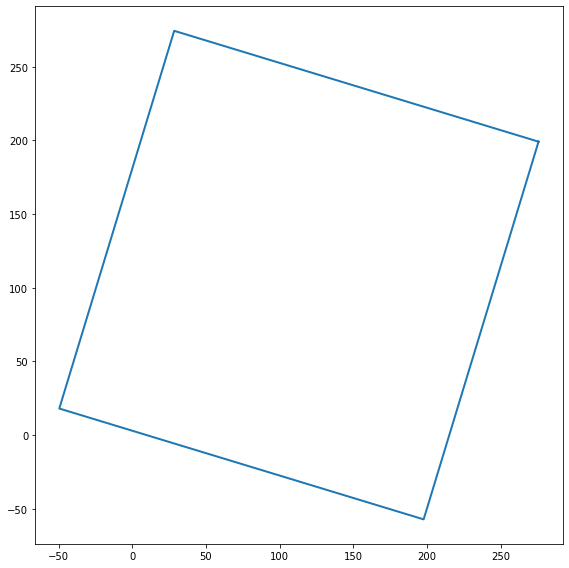

In [ ]:
paths = []
fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))

for curve_set, node_sequence in closed_curves.items():
    new_path = reconstruct_single_curve(node_sequence,umap,XY,partner)
    fv = extract_features(new_path)
    fv = fv.reshape(1, -1)
    shape = model.predict(fv)

    if(shape == 'rectangle'):
        print(curve_set)
        corners = find_corners(new_path)
        print(corners)
        reg_corners = pca_bounding_box(corners)
        reg_corners = np.vstack([reg_corners, reg_corners[0]])
        ax.plot (reg_corners[:, 0], reg_corners[:, 1], linewidth =2)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
def dfs_find_open_paths(node, parent, visited, path, curves_in_path, adj_list, unique_paths):
    path.append(node)
    visited.add(node)

    is_end = True  # To check if it's an endpoint

    for neighbor, curve_number in adj_list[node]:
        if neighbor != parent:
            is_end = False
            if neighbor not in visited:
                dfs_find_open_paths(neighbor, node, visited, path, curves_in_path + [curve_number], adj_list, unique_paths)

    # Check if the node is an endpoint (no other neighbors except its parent)
    if is_end and parent is not None and euclidean_distance(umap[parent], umap[node]) >= 5:
        path_representation = frozenset(curves_in_path)
        if path_representation not in unique_paths:
            unique_paths[path_representation] = list(path)

    path.pop()
    visited.remove(node)

# Function to find all open curves
def find_open_curves(adj_list, num_nodes):
    unique_paths = {}

    for start_node in range(num_nodes):
        visited = set()
        if(len(adjacency_list[start_node])==1):
            dfs_find_open_paths(start_node, None, visited, [], [], adj_list, unique_paths)

    return unique_paths

num_nodes = len(adjacency_list)

# Find all open curves
open_curves = find_open_curves(adjacency_list, num_nodes)


In [ ]:
open_curves

{}

In [ ]:
len(open_curves)

0

In [ ]:
for i, (curve_set, path) in enumerate(open_curves.items()):
    fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
    for el in curve_set:
        ax.plot (XY[el][:, 0], XY[el][:, 1], linewidth =2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import nbformat as nbf

# Define the function to find symmetry and complete occluded images
def find_symmetry_and_complete(image):
    """
    Finds the symmetry of a regular shape and completes the shape if the given image is occluded.

    Parameters:
    image (numpy array): The input image containing the shape.

    Returns:
    completed_image (numpy array): The image with the completed shape.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the shape
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the shape
    contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box and symmetry axis (for simplicity, assume vertical symmetry)
    x, y, w, h = cv2.boundingRect(contour)
    symmetry_axis = x + w // 2

    # Reflect the shape across the symmetry axis to complete occlusions
    reflected_contour = np.array([[2 * symmetry_axis - pt[0], pt[1]] for pt in contour.squeeze()])

    # Create a mask from the original contour and reflected contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    cv2.drawContours(mask, [reflected_contour], -1, 255, -1)

    # Combine the original image with the mask
    completed_image = cv2.bitwise_and(image, image, mask=mask)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Completed Shape with Symmetry")
    plt.imshow(cv2.cvtColor(completed_image, cv2.COLOR_BGR2RGB))
    plt.show()

    return completed_image

# Insert this function into the combined notebook
combined_notebook_path = '/mnt/data/combined_curves_processing.ipynb'

with open(combined_notebook_path, 'r') as f:
    combined_notebook = nbf.read(f, as_version=4)

# Create a new code cell for the function
symmetry_code_cell = nbf.v4.new_code_cell("""
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_symmetry_and_complete(image):
    \"\"\"
    Finds the symmetry of a regular shape and completes the shape if the given image is occluded.

    Parameters:
    image (numpy array): The input image containing the shape.

    Returns:
    completed_image (numpy array): The image with the completed shape.
    \"\"\"
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the shape
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the shape
    contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box and symmetry axis (for simplicity, assume vertical symmetry)
    x, y, w, h = cv2.boundingRect(contour)
    symmetry_axis = x + w // 2

    # Reflect the shape across the symmetry axis to complete occlusions
    reflected_contour = np.array([[2 * symmetry_axis - pt[0], pt[1]] for pt in contour.squeeze()])

    # Create a mask from the original contour and reflected contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    cv2.drawContours(mask, [reflected_contour], -1, 255, -1)

    # Combine the original image with the mask
    completed_image = cv2.bitwise_and(image, image, mask=mask)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Completed Shape with Symmetry")
    plt.imshow(cv2.cvtColor(completed_image, cv2.COLOR_BGR2RGB))
    plt.show()

    return completed_image
""")

# Add the new cell to the end of the combined notebook
combined_notebook.cells.append(symmetry_code_cell)

# Save the updated notebook
with open(combined_notebook_path, 'w') as f_out:
    nbf.write(combined_notebook, f_out)

combined_notebook_path


# **Seperate the Occluded Shapes from the given Image and Completing them**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def separate_and_complete_shapes(image):
    """
    Separates occluded shapes from the image and completes them.

    Parameters:
    image (numpy array): The input image containing occluded shapes.

    Returns:
    completed_image (numpy array): The image with completed shapes.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the shapes
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to store the completed shapes
    completed_image = np.zeros_like(image)

    for contour in contours:
        # Create a mask for the individual shape
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], -1, 255, -1)

        # Extract the shape from the original image
        shape = cv2.bitwise_and(image, image, mask=mask)

        # Find symmetry and complete the shape
        completed_shape = find_symmetry_and_complete(shape)

        # Combine the completed shape back into the final image
        completed_image = cv2.bitwise_or(completed_image, completed_shape)

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Completed Image with Separated Shapes")
    plt.imshow(cv2.cvtColor(completed_image, cv2.COLOR_BGR2RGB))
    plt.show()

    return completed_image
